In [1]:
import logging

import numpy as np
import optimistix as optx
from atmodeller import (
    InteriorAtmosphere,
    Planet,
    Species,
    SpeciesCollection,
    debug_logger,
    earth_oceans_to_hydrogen_mass,
    SolverParameters,
)
from atmodeller.eos import get_eos_models
from atmodeller.solubility import get_solubility_models
from atmodeller.thermodata import IronWustiteBuffer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d
import os

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

logger = debug_logger()
logger.setLevel(logging.INFO)

# For more output use DEBUG
# logger.setLevel(logging.DEBUG)

Atmodeller initialized with double precision (float64)


In [2]:
R_earth = 6371000
M_earth = 5.972e24
R_uranus = 3.979310 * R_earth #Nettelman 2013 U1
number_of_realisations = 50
surface_temperature = 5000  # Based On Nettelman 2013U1
planet_mass = 14.5322753*M_earth 

#defining now for different regions
core_mass = 0.5984897*M_earth #Nettelman 2013 U1
core_radius = 0.700034*R_earth
core_temperature = 6083.6 
#core_mass = 0.11*planet_mass  #Based on #https://arxiv.org/pdf/2412.06010
#r_core = 0.2*R_uranus  # Nettelman 2013

#now for MEB, based on Kaustub mass-relation for rocky planets R_P = 1.02*M_earth^0.252 = 2 R_earth
MBE_radius = 2*R_earth 
MBE_temperature = 4500 # https://www.pnas.org/doi/10.1073/pnas.2403981121
MBE_mass = 0.36*planet_mass # https://www.pnas.org/doi/10.1073/pnas.2403981121

#region of full mantle, boundary between inner and outer envelope
boundary_radius = 0.772*R_uranus #Nettelman 2013 U1
boundary_temperature = 2338.8
boundary_mass = 0.913*planet_mass #Nettelman 2013 U1


mantle_melt_fraction = 1.0  # 0.1 -> we will iterate 
planet_mass = MBE_mass

RANDOM_SEED = 0

np.random.seed(RANDOM_SEED)

In [3]:
H_masspercent_lodders09: float = 73.9
He_masspercent_lodders09: float = 24.69
C_masspercent_lodders09: float = 0.22
N_masspercent_lodders09: float = 0.07
O_masspercent_lodders09: float = 0.63
Si_masspercent_lodders09: float = 0.07
Mg_masspercent_lodders09: float = 0.06

H_logN: float = 12
He_logN: float = 10.93
C_logN: float = 8.39
N_logN: float = 7.86
O_logN: float = 8.73
Si_logN: float = 7.53
Mg_logN: float = 7.54 

In [4]:
#SiO2 for primitive composition of Earth
SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
core_mass_fraction: float = 0.327  # typical values used are between 0.325 - 0.33
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme14: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999


hmps = np.logspace(-1, 0, num=number_of_realisations)  # wt% H
h_kgs = hmps / 100 * boundary_mass  # kg

si_kg_magma: float = Si_massfraction_palme14 * planet_mass
o_kg_magma: float = O_massfraction_palme14 * planet_mass

# Lodders et al. (2009) Springer book chapter Table 8
si_kgs_solar = h_kgs * Si_masspercent_lodders09 / H_masspercent_lodders09
o_kgs_solar = h_kgs * O_masspercent_lodders09 / H_masspercent_lodders09
c_kgs_solar = h_kgs * C_masspercent_lodders09 / H_masspercent_lodders09
n_kgs_solar = h_kgs * N_masspercent_lodders09 / H_masspercent_lodders09
he_kgs_solar = h_kgs * He_masspercent_lodders09 / H_masspercent_lodders09

In [ ]:
#hmps = np.logspace(-1, 0,num=500)
hmps = 0.6
#many possible reasons, like solubility
metall = 1
#Make arrays of everything

h_kgs = hmps / 100 * planet_mass  # kg

si_kg_magma: float = Si_massfraction_palme14 * planet_mass
o_kg_magma: float = O_massfraction_palme14 * planet_mass

# Lodders et al. (2009) Springer book chapter Table 8
si_kgs_solar = h_kgs * Si_masspercent_lodders09 / H_masspercent_lodders09
mg_kgs_solar = h_kgs * Mg_masspercent_lodders09 / H_masspercent_lodders09
o_kgs_solar = h_kgs * O_masspercent_lodders09 / H_masspercent_lodders09
c_kgs_solar = h_kgs * C_masspercent_lodders09 / H_masspercent_lodders09
n_kgs_solar = h_kgs * N_masspercent_lodders09 / H_masspercent_lodders09
he_kgs_solar = h_kgs * He_masspercent_lodders09 / H_masspercent_lodders09

mass_constraints = {
    "H": h_kgs,
    "He": he_kgs_solar,
    "C": metall * c_kgs_solar,
    "N": metall * n_kgs_solar,
    "Si": metall * si_kgs_solar + mantle_melt_fraction * si_kg_magma,
    "O": metall * o_kgs_solar + mantle_melt_fraction * o_kg_magma
        }

In [6]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = Species.create_gas("H2O")
H2O_gs = Species.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = Species.create_gas("H2")
H2_gs = Species.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = Species.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = Species.create_gas("O2")
O2_rg = Species.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = Species.create_gas("OSi")
OSi_rg = Species.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = Species.create_gas("H4Si")
H4Si_rg = Species.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = Species.create_condensed("O2Si", state="l")
O2Si_bqz = Species.create_condensed("O2Si", state="bqz")

CO2_g = Species.create_gas("CO2")
CO2_gs = Species.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = Species.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)

CO_g = Species.create_gas("CO")
CO_gs = Species.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = Species.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)

CH4_g = Species.create_gas("CH4")
CH4_gs = Species.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = Species.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)

N2_g = Species.create_gas("N2")
N2_gs = Species.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = Species.create_gas(
    "N2", solubility=sol_models["N2_basalt_libourel03"], activity=eos_models["N2_cs_saxena87"]
)

NH3_g = Species.create_gas("NH3")
NH3_rg = Species.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = Species.create_gas("He")
He_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = Species.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)


species_HHeCNOSi_magma_nosol_ideal = SpeciesCollection(
    (H2O_g, H2_g, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_g, CO_g, CH4_g, N2_g, NH3_g, He_g)
)
species_HHeCNOSi_magma_sol_ideal = SpeciesCollection(
    (H2O_gs, H2_gs, O2_g, OSi_g, H4Si_g, O2Si_l, CO2_gs, CO_gs, CH4_gs, N2_gs, NH3_g, He_gs)
)
species_HHeCNOSi_magma_sol_real = SpeciesCollection(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
        CO2_rgs,
        CO_rgs,
        CH4_rgs,
        N2_rgs,
        NH3_rg,
        He_rgs,
    )
)

In [ ]:
Uranus = Planet(
    surface_temperature=MBE_temperature,
    planet_mass=planet_mass,
    mantle_melt_fraction=mantle_melt_fraction,
    surface_radius=MBE_radius
    )
# Show its attributes
print(vars(Uranus))

# Show methods and all attributes
print(dir(Uranus))
model_magma_nosol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_nosol_ideal)
model_magma_nosol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
         )
output_magma_nosol_ideal = model_magma_nosol_ideal.output
output_magma_nosol_ideal.quick_look()
output_magma_nosol_ideal.to_excel("HHeCNOSi_magma_nosol_ideal")

model_magma_sol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_sol_ideal)
initial_log_number_density = output_magma_nosol_ideal.log_number_density
model_magma_sol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        initial_log_number_density=initial_log_number_density,
        )
output_magma_sol_ideal = model_magma_sol_ideal.output
output_magma_sol_ideal.quick_look()
output_magma_sol_ideal.to_excel("HHeCNOSi_magma_sol_ideal")

model_magma_sol_real = InteriorAtmosphere(species_HHeCNOSi_magma_sol_real)
initial_log_number_density = output_magma_sol_ideal.log_number_density
model_magma_sol_real.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        initial_log_number_density=initial_log_number_density,
        )
output_magma_sol_real = model_magma_sol_real.output
output_magma_sol_real.quick_look()
output_magma_sol_real.to_excel("HHeCNOSi_magma_sol_real")

filename = "HHeCNOSi_magma_sol_real.xlsx"

[09:27:22 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'He_g: IdealGas, NoSolubility')
[09:27:22 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2_g + 0.5 O2Si_l = 1.0 H2O_g + 0.5 H4Si_g',
 1: '0.5 H4Si_g + 1.0 CO2_g = 1.0 H2_g + 0.5 O2Si_l + 1.0 CO_g',
 2: '1.0 H4Si_g + 1.0 CO2_g = 1.0 O2Si_l + 1.0 CH4_g',
 3: '0.5 H4Si_g + 0.5 O2Si_l = 1.0 H2_g + 1.0 OSi_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g'}
[09:27:22 - atmodeller.classes             - INFO     ] - Attempting to solve 1 model(s)


{'planet_mass': Array(3.1243229312976e+25, dtype=float64), 'core_mass_fraction': Array(0.295334691460966, dtype=float64), 'mantle_melt_fraction': Array(1., dtype=float64), 'surface_radius': Array(12742000., dtype=float64), 'surface_temperature': Array(4500., dtype=float64)}
['__abstractclassvars__', '__abstractmethods__', '__abstractvars__', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'asdict', 'core_mass_fraction', 'mantle_mass', 'mantle_mass_fraction', 'mantle_melt_fraction', 'mantle_melt_mass', 'mantle_solid_mass', 'mass', 'melt_mass', 'planet_mass', 'solid_mass',

[09:27:27 - atmodeller.classes             - INFO     ] - Solve complete: 1 (100.00%) successful model(s)
[09:27:27 - atmodeller.classes             - INFO     ] - Solver steps (max) = 25
[09:27:28 - atmodeller.output              - INFO     ] - Writing output to excel
[09:27:28 - atmodeller.output              - INFO     ] - Computing to_dataframes output
[09:27:28 - atmodeller.output              - INFO     ] - Computing asdict output
[09:27:34 - atmodeller.output              - INFO     ] - Output written to HHeCNOSi_magma_nosol_ideal.xlsx
[09:27:34 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, SolubilityPowerLaw', 'H2_g: IdealGas, SolubilityPowerLawLog10', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'CO2_g: IdealGas, _CO2_basalt_dixon95', 'CO_g: IdealGas, _CO_basalt_yoshioka19', 'CH4_g: IdealGas, _CH4_basalt_ardia13', 'N2_g: IdealGas, _N2_basalt_libourel

In [ ]:
color_tot = "black"
color_H2 = "orange"
color_H2O = "blue"
color_SiH4 = "red"
color_SiO = "brown"
color_O2 = "limegreen"
color_H = "orange"
color_O = "blue"
color_Si = "red"

In [ ]:
H2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["pressure"]
H2O_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["pressure"]
O2_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["pressure"]
SiH4_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["pressure"]
SiO_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["pressure"]
tot_pressure_magma_sol_real = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_moles"]
O_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_moles"]
Si_moles_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_moles"]

H_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_moles"]
O_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_moles"]
Si_moles_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_moles"]

H_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_moles"]
O_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_moles"]
Si_moles_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_moles"]

H_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["atmosphere_mass"]
O_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["atmosphere_mass"]
Si_mass_atm_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["atmosphere_mass"]

H_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["dissolved_mass"]
O_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["dissolved_mass"]
Si_mass_melt_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["dissolved_mass"]

H_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_H")["total_mass"]
O_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_O")["total_mass"]
Si_mass_tot_magma_sol_real = pd.read_excel(filename, sheet_name="element_Si")["total_mass"]

H2_fc_magma_sol_real = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_magma_sol_real = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_magma_sol_real = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_magma_sol_real = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_magma_sol_real = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

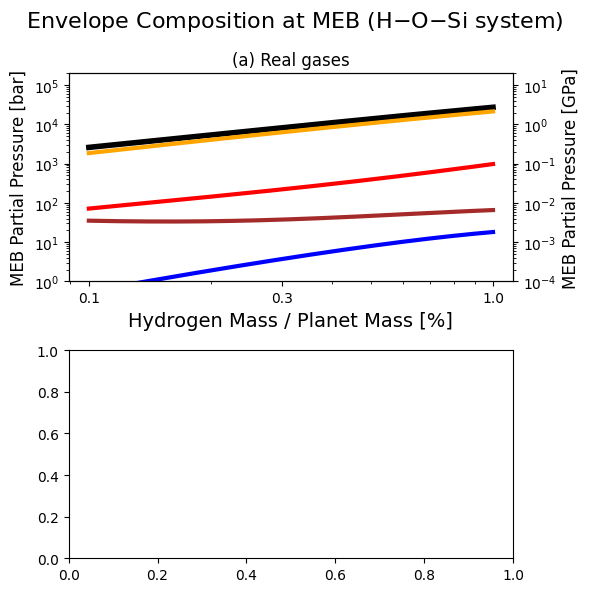

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(6, 6), tight_layout="True")


ax0.plot(hmps, tot_pressure_magma_sol_real, color=color_tot, lw=4, ls="-", label="Total")
ax0.plot(hmps, H2_pressure_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
ax0.plot(hmps, H2O_pressure_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
ax0.plot(hmps, SiH4_pressure_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
ax0.plot(hmps, SiO_pressure_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

ax0.set_title(r"(a) Real gases")
ax0.set_ylim([1e0, 2e5])
ax0.set_xscale("log")
ax0.set_yscale("log")
ax0.set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=14)
ax0.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
ax0.set_xticks([0.1, 0.3, 1])
ax0.get_xaxis().set_major_formatter(ScalarFormatter())

ax00 = ax0.twinx()
ax00.set_yscale("log")
ax00.set_ylabel(r"MEB Partial Pressure [GPa]", fontsize=12)
ax00.set_ylim([1e-4, 2e1])

fig.suptitle(f"Envelope Composition at MEB (H$-$O$-$Si system)", fontsize=16)

plt.savefig(f"HOSi_envelope.pdf", bbox_inches="tight")
plt.savefig(f"HOSi_envelope.png", bbox_inches="tight")
plt.show()

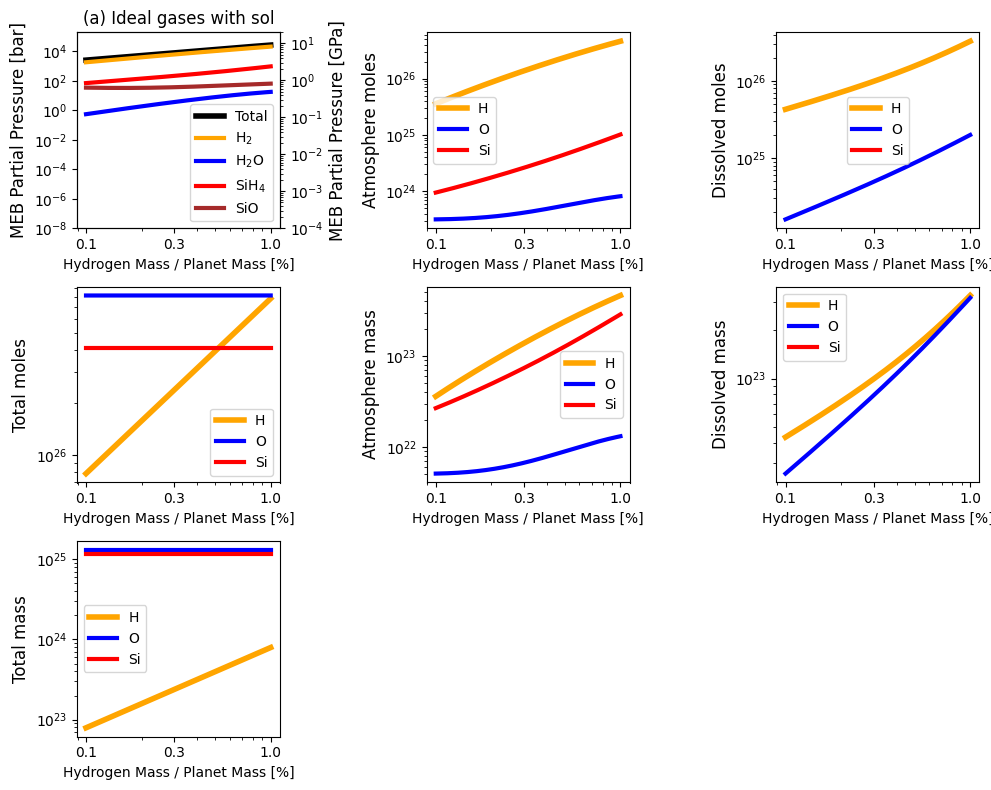

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.flatten()  # flatten 2D array of axes to 1D list

axes[0].plot(hmps, tot_pressure_magma_sol_real, color=color_tot, lw=4, ls="-", label="Total")
axes[0].plot(hmps, H2_pressure_magma_sol_real, color=color_H2, lw=3, ls="-", label="H$_2$")
axes[0].plot(hmps, H2O_pressure_magma_sol_real, color=color_H2O, lw=3, ls="-", label="H$_2$O")
axes[0].plot(hmps, SiH4_pressure_magma_sol_real, color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
axes[0].plot(hmps, SiO_pressure_magma_sol_real, color=color_SiO, lw=3, ls="-", label="SiO")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

axes[0].set_title(r"(a) Ideal gases with sol")
axes[0].set_ylim([1e-8, 2e5])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[0].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
axes[0].set_xticks([0.1, 0.3, 1])
axes[0].get_xaxis().set_major_formatter(ScalarFormatter())

axes[0].legend(fontsize=10, loc='best') 
ax0 = axes[0].twinx()
ax0.set_yscale("log")
ax0.set_ylabel(r"MEB Partial Pressure [GPa]", fontsize=12)
ax0.set_ylim([1e-4, 2e1])


axes[1].plot(hmps, H_moles_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[1].plot(hmps, O_moles_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[1].plot(hmps, Si_moles_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[1].set_ylabel("Atmosphere moles", fontsize=12)
axes[1].set_xticks([0.1, 0.3, 1])
axes[1].get_xaxis().set_major_formatter(ScalarFormatter())
axes[1].legend(fontsize=10, loc='best') 


axes[2].plot(hmps, H_moles_melt_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[2].plot(hmps, O_moles_melt_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[2].plot(hmps, Si_moles_melt_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[2].set_ylabel("Dissolved moles", fontsize=12)
axes[2].set_xticks([0.1, 0.3, 1])
axes[2].get_xaxis().set_major_formatter(ScalarFormatter())
axes[2].legend(fontsize=10, loc='best') 


axes[3].plot(hmps, H_moles_tot_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[3].plot(hmps, O_moles_tot_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[3].plot(hmps, Si_moles_tot_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[3].set_xscale("log")
axes[3].set_yscale("log")
axes[3].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[3].set_ylabel("Total moles", fontsize=12)
axes[3].set_xticks([0.1, 0.3, 1])
axes[3].get_xaxis().set_major_formatter(ScalarFormatter())
axes[3].legend(fontsize=10, loc='best') 


axes[4].plot(hmps, H_mass_atm_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[4].plot(hmps, O_mass_atm_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[4].plot(hmps, Si_mass_atm_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[4].set_xscale("log")
axes[4].set_yscale("log")
axes[4].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[4].set_ylabel("Atmosphere mass", fontsize=12)
axes[4].set_xticks([0.1, 0.3, 1])
axes[4].get_xaxis().set_major_formatter(ScalarFormatter())
axes[4].legend(fontsize=10, loc='best') 


axes[5].plot(hmps, H_mass_melt_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[5].plot(hmps, O_mass_melt_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[5].plot(hmps, Si_mass_melt_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[5].set_xscale("log")
axes[5].set_yscale("log")
axes[5].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[5].set_ylabel("Dissolved mass", fontsize=12)
axes[5].set_xticks([0.1, 0.3, 1])
axes[5].get_xaxis().set_major_formatter(ScalarFormatter())
axes[5].legend(fontsize=10, loc='best') 


axes[6].plot(hmps, H_mass_tot_magma_sol_real, color=color_H, lw=4, ls="-", label="H")
axes[6].plot(hmps, O_mass_tot_magma_sol_real, color=color_O, lw=3, ls="-", label="O")
axes[6].plot(hmps, Si_mass_tot_magma_sol_real, color=color_Si, lw=3, ls="-", label="Si")
# ax0.plot(hmps, O2_pressure_magma_sol_real, color=color_O2, lw=3, ls= '-', label='O$_2$')

#axes[1].set_ylim([1e0, 2e5])
axes[6].set_xscale("log")
axes[6].set_yscale("log")
axes[6].set_xlabel(r"Hydrogen Mass / Planet Mass [%]", fontsize=10)
axes[6].set_ylabel("Total mass", fontsize=12)
axes[6].set_xticks([0.1, 0.3, 1])
axes[6].get_xaxis().set_major_formatter(ScalarFormatter())
axes[6].legend(fontsize=10, loc='best') 

# Hide unused subplots
for j in range(7, 9):
    axes[j].axis("off")

plt.tight_layout()
plt.show()